In [1]:
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names
import numpy as np
from pandas import Series
import seaborn as sns
from matplotlib.pyplot import figure
import cmocean.cm as cmo
import seaborn as sns

from pylab import rcParams
from numpy import diff
from scipy import interpolate
import scipy.stats as stats

from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

import matplotlib.gridspec as gridspec

import cmocean
import cmocean.cm as cmo
import seaborn as sns


import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

## import data

In [2]:
df_o2 = pd.read_csv('../Dissertation_projects/Data/CTD/O2_Summary_Stats.csv', sep=',', index_col=0)

In [3]:
df_doc = pd.read_csv('../Dissertation_projects/Data/TOC/TOC_GOM.csv', sep=',', index_col=0)

#make all BDL a 0 
df_doc.loc[df_doc['NPOC_uM'] == 'BLD', 'NPOC_uM'] = 0
df_doc.loc[df_doc['TN_uM'] == 'BLD', 'TN_uM'] = 0

df_doc.loc[df_doc['NPOC_uM'] < 0, 'NPOC_uM'] = 0
df_doc.loc[df_doc['TN_uM'] < 0, 'TN_uM'] = 0

#fix date time 
df_doc['date_time'] = pd.to_datetime(df_doc['Date'])
df_doc['Date'] = df_doc['date_time'].dt.date

df_doc['NPOC_uM'] = pd.to_numeric(df_doc['NPOC_uM'], errors='coerce')
df_doc['NPOC_uM'] = df_doc['NPOC_uM'].where(pd.notna(df_doc['NPOC_uM']), other=np.nan)

df_doc['TN_uM'] = pd.to_numeric(df_doc['TN_uM'], errors='coerce')
df_doc['TN_uM'] = df_doc['TN_uM'].where(pd.notna(df_doc['TN_uM']), other=np.nan)

df_doc['Time'] = pd.to_numeric(df_doc['Time'], errors='coerce')
df_doc['Time'] = df_doc['Time'].where(pd.notna(df_doc['Time']), other=np.nan)

df_doc['code'] = df_doc['Location'] + '_' + df_doc['Campaign']

df_doc = df_doc.drop(222101, axis=0) #St.13 gom22sp depth 1 suspected contam 
df_doc = df_doc.drop(212211, axis=0) #St.14 gom2021 overlying water  
#df_doc = df_doc.drop(215401, axis=0) #St.13 gom21fa depth 1 suspected contam 

In [4]:
df_meta = pd.read_csv('../Dissertation_projects/Data/meta_data.csv', sep=',', index_col=0)

#fix date time 
df_meta['date_time'] = pd.to_datetime(df_meta['Date'])
df_meta['Date'] = df_meta['date_time'].dt.date

df_meta['code'] = df_meta['Station'] + '_' + df_meta['Trip']

In [5]:
df_por = pd.read_csv('../Dissertation_projects/Data/Porosity/Porosity.csv', sep=',', index_col = 0)
df_por['code'] = df_por['Stn'] + '_' + df_por['camp']

In [6]:
df_hights = pd.read_csv('../Dissertation_projects/Data/Hights.csv', sep=',')

df_hights['code'] = df_hights['Stn'] + '_' + df_hights['Camp']
#df_hights.drop("Stn", axis=1, inplace=True)
#df_hights.drop("Camp", axis=1, inplace=True)
df_hights.index = df_hights['code']
df_hights.drop("code", axis=1, inplace=True)

In [7]:
#get BC data sets 
df_doc_bc = df_doc[df_doc['Type'] == 'BC']

#get PW data sets 
df_doc_pw = df_doc[df_doc['Type'] == 'PW']

#get WC data sets 
df_doc_wc = df_doc[df_doc['Type'] == 'WC']

#get RHZ data 
df_doc_rz = df_doc[df_doc['Type'] == 'RZ']

## Data for flux calculations 

In [8]:
#hights data
df_hights = pd.read_csv('../Dissertation_projects/Data/Hights.csv', sep=',')

df_hights['code'] = df_hights['Stn'] + '_' + df_hights['Camp']
#df_hights.drop("Stn", axis=1, inplace=True)
#df_hights.drop("Camp", axis=1, inplace=True)
df_hights.index = df_hights['code']
df_hights.drop("code", axis=1, inplace=True)

In [9]:
#porosity data 
df_por = pd.read_csv('../Dissertation_projects/Data/Porosity/Porosity.csv', sep=',', index_col = 0)
df_por['code'] = df_por['Stn'] + '_' + df_por['camp']

In [10]:
#location data 
df_lat_lon = df_meta.groupby('code').agg({'Lat': 'mean', 'Lon': 'mean'}).reset_index().set_index('code')

## slope calculations

In [11]:
#figure calculate pore water 

#DOC slopes pore water 
df_doc_pw_plot = df_doc_pw[(df_doc_pw['NPOC_uM'] != 0)]
#df_doc_pw_plot = df_doc_pw_plot[(df_doc_pw_plot['Depth'] >= 0)]
df_doc_pw_plot = df_doc_pw_plot.dropna(subset=["NPOC_uM"])
df_doc_pw_plot = df_doc_pw_plot.sort_values(by='code')
codes = df_doc_pw_plot['code'].unique()

print(codes)
len(codes)

df_doc_pw_plot[df_doc_pw_plot['code'] == 'St.13_GOM22SP']

['St.11_GOM2021' 'St.11_GOM21FA' 'St.11_GOM22SU' 'St.12_GOM21FA'
 'St.12_GOM22SU' 'St.13_GOM21FA' 'St.13_GOM22SP' 'St.13_GOM22SU'
 'St.14_GOM2021' 'St.14_GOM21FA' 'St.14_GOM22SP' 'St.14_GOM22SU'
 'St.15_GOM2021' 'St.15_GOM21FA' 'St.15_GOM22SP' 'St.15_GOM22SU'
 'St.16_GOM2021' 'St.16_GOM21FA' 'St.16_GOM22SP' 'St.16_GOM22SU'
 'St.2_GOM2021' 'St.2_GOM21FA' 'St.2_GOM22SP' 'St.2_GOM22SU'
 'St.4_GOM2021' 'St.4_GOM21FA' 'St.4_GOM22SP' 'St.4_GOM22SU'
 'St.5B_GOM2021' 'St.5B_GOM21FA' 'St.5B_GOM22SP' 'St.5B_GOM22SU'
 'St.7_GOM2021' 'St.7_GOM21FA' 'St.7_GOM22SP' 'St.7_GOM22SU'
 'St.9_GOM2021' 'St.9_GOM21FA' 'St.9_GOM22SP' 'St.9_GOM22SU'
 'St.MK_GOM2021' 'St.MK_GOM21FA' 'St.MK_GOM22SP' 'St.MK_GOM22SU']


,Treatment,Campaign,Date,Location,NPOC Conc (mg/L),TN Conc (mg/L),Depth,Notes,Type,Time,Dil Factor,NPOC_uM,TN_uM,dil_fac,NPOC_uM_std,TN_uM_std,date_time,code
Sample ID,,,,,,,,,,,,,,,,,,
222106,P2F,GOM22SP,2022-04-19,St.13,6.745768,0.591075025,3.85,Bad Curve/ Used last standerd curve,PW,NaN,15.000000,562.147320,42.219645,15.000000,11.242259,0.844699,2022-04-19,St.13_GOM22SP
222114,P2F,GOM22SP,2022-04-19,St.13,7.759216,1.632762728,12.95,Bad Curve/ Used last standerd curve,PW,NaN,15.000000,646.601316,116.625909,15.000000,12.931236,2.333365,2022-04-19,St.13_GOM22SP
222105,P2F,GOM22SP,2022-04-19,St.13,4.137167,0.346809664,3.15,Bad Curve/ Used last standerd curve,PW,NaN,15.000000,344.763908,24.772119,15.000000,6.894857,0.495622,2022-04-19,St.13_GOM22SP
222104,P2F,GOM22SP,2022-04-19,St.13,4.739978,0.414722006,2.45,Bad Curve/ Used last standerd curve,PW,NaN,15.000000,394.998144,29.623000,15.000000,7.899480,0.592675,2022-04-19,St.13_GOM22SP
222107,P2F,GOM22SP,2022-04-19,St.13,7.292667,0.684947408,4.70,Bad Curve/ Used last standerd curve,PW,NaN,15.000000,607.722239,48.924815,15.000000,12.153702,0.978852,2022-04-19,St.13_GOM22SP
222100,P2F,GOM22SP,2022-04-19,St.13,2.895258,0.344180799,0.00,Bad Curve/ Used last standerd curve,PW,NaN,15.000000,241.271506,24.584343,15.000000,4.825135,0.491865,2022-04-19,St.13_GOM22SP
222108,P2F,GOM22SP,2022-04-19,St.13,8.570122,0.879045264,5.70,Bad Curve/ Used last standerd curve,PW,NaN,15.000000,714.176855,62.788947,15.000000,14.282664,1.256235,2022-04-19,St.13_GOM22SP
222102,P2F,GOM22SP,2022-04-19,St.13,3.819099,0.234097083,1.05,Bad Curve/ Used last standerd curve,PW,NaN,15.000000,318.258251,16.721220,15.000000,6.364776,0.334546,2022-04-19,St.13_GOM22SP
222110,P2F,GOM22SP,2022-04-19,St.13,7.089563,0.507909467,7.70,Bad Curve/ Used last standerd curve,PW,NaN,47.666667,590.796892,36.279248,47.666667,11.815216,0.725848,2022-04-19,St.13_GOM22SP


df_doc_wc_plot = df_doc_wc[df_doc_wc['code'].isin(codes)]

max_depth_per_code = df_doc_wc_plot.groupby('code')['Depth'].max().reset_index()
df_doc_wc_plot = pd.merge(df_doc_wc_plot, max_depth_per_code, on='code', suffixes=('', '_max'))
df_doc_wc_plot = df_doc_wc_plot[df_doc_wc_plot['Depth'] == df_doc_wc_plot['Depth_max']]
df_doc_wc_plot.drop(columns=['Depth_max'], inplace=True)

#mean_doc = df_doc_wc_plot.groupby('code')['NPOC_uM'].mean().reset_index()
#mean_tn = df_doc_wc_plot.groupby('code')['TN_uM'].mean().reset_index()
#std_doc = df_doc_wc_plot.groupby('code')['NPOC_uM_std'].mesuan().reset_index()
#stc_tn = df_doc_wc_plot.groupby('code')['NPOC_uM_std'].mean().reset_index()

df_doc_wc_plot['Depth_sample'] = df_doc_wc_plot['Depth']
df_doc_wc_plot['Depth'] = -0.5

# Calculate the mean of "NPOC_uM", "TN_uM", and "Depth" for each group in 'code'
df_doc_wc_plot = df_doc_wc_plot.groupby('code').agg({'NPOC_uM': 'mean', 'TN_uM': 'mean', 'Depth': 'mean', 'NPOC_uM_std': 'sum', 'TN_uM_std': 'sum'}).reset_index()


# Display the result dataframe
df_doc_wc_plot


df_concatenated = pd.concat([df_doc_pw_plot, df_doc_wc_plot], ignore_index=True)
df_doc_pw_plot = df_concatenated.sort_values(by='code')
df_doc_pw_plot

# Group by the specified groups
groups = ['code']

grouped = df_doc_pw_plot.groupby(groups)

# Function to find the row with the smallest non-negative depth in each group
def get_min_depth_row(group):
    non_negative_depth = group[group['Depth'] >= 0]
    min_depth_row = non_negative_depth[non_negative_depth['Depth'] == non_negative_depth['Depth'].min()]
    return min_depth_row

# Apply the function to each group
filtered_df = grouped.apply(get_min_depth_row).reset_index(drop=True)

# Find the min and max NPOC_uM values
min_npoC_uM = filtered_df['NPOC_uM'].min()
max_npoC_uM = filtered_df['NPOC_uM'].max()

print("Min NPOC_uM:", min_npoC_uM)
print("Max NPOC_uM:", max_npoC_uM)

filtered_df['NPOC_uM']

sorted_filtered_df = filtered_df.sort_values(by='NPOC_uM')

sorted_filtered_df['NPOC_uM']

In [12]:
mw = np.arange(1000, 2001, 1)

Do = (1.1 * 1e-3) * (mw ** -.81) 
print(Do.min())
print(Do.max())


2.3310864968650406e-06
4.086887520068897e-06


C:\Users\hmlbr\AppData\Local\Temp\ipykernel_12832\3656650087.py:11: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  yy = sub.loc[(sub['Depth'] < depth1) & (sub['Depth'] > depth2), 'Depth'].ravel()
C:\Users\hmlbr\AppData\Local\Temp\ipykernel_12832\3656650087.py:12: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  xx = sub.loc[(sub['Depth'] < depth1) & (sub['Depth'] > depth2), 'NPOC_uM'].ravel()
C:\Users\hmlbr\AppData\Local\Temp\ipykernel_12832\3656650087.py:25: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  xx2 = sub.loc[(sub['Depth'] < depth1) & (sub['Depth'] > depth2), 'Depth'].ravel() / 1000
C:\Users\hmlbr\AppData\Local\Temp\ipykerne

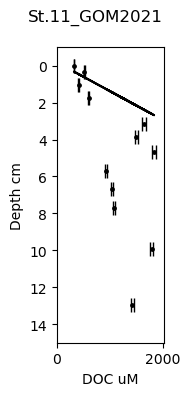

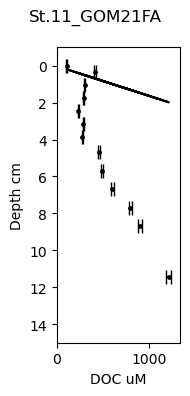

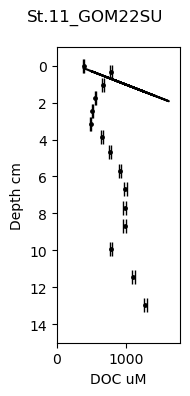

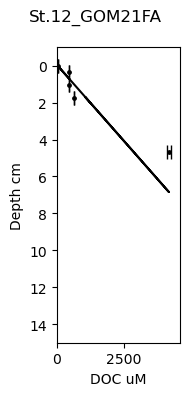

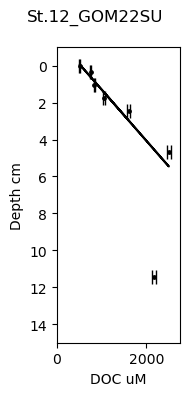

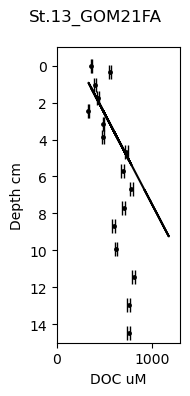

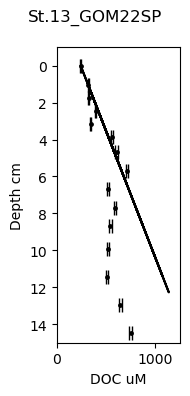

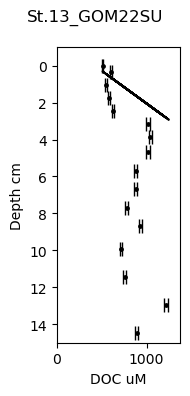

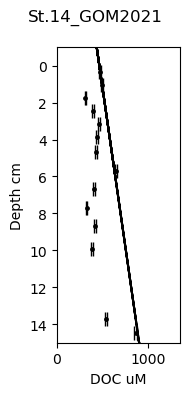

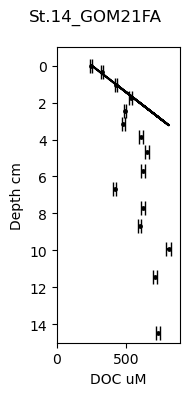

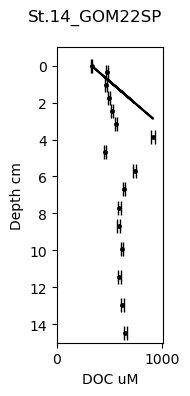

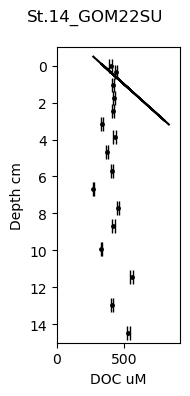

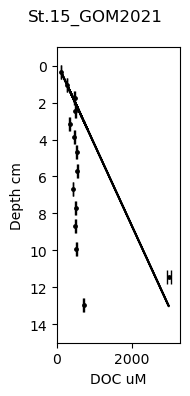

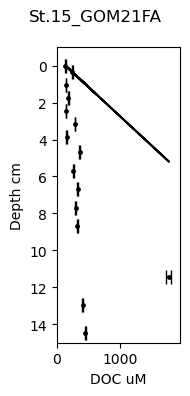

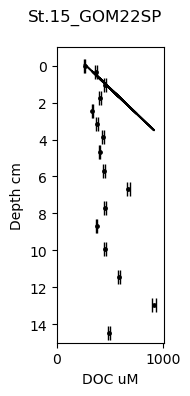

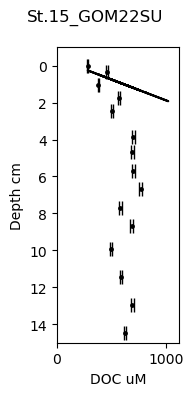

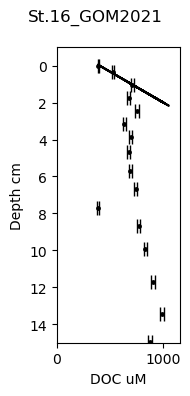

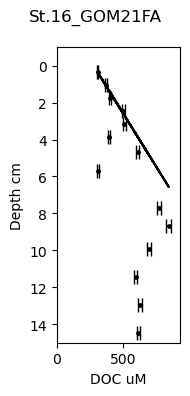

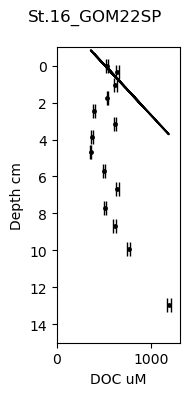

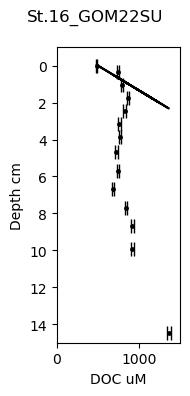

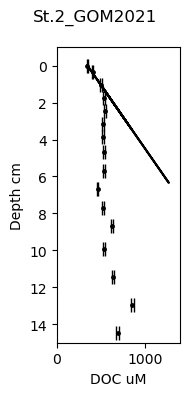

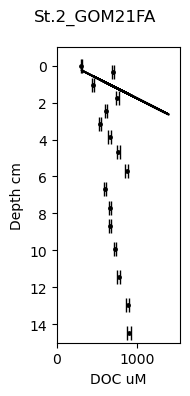

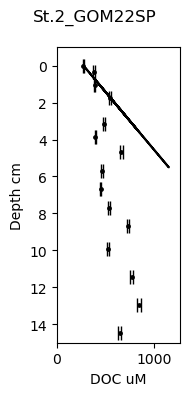

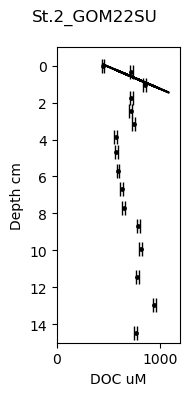

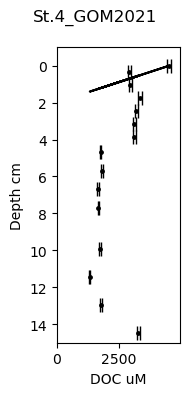

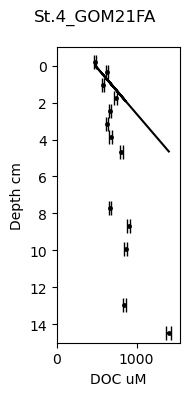

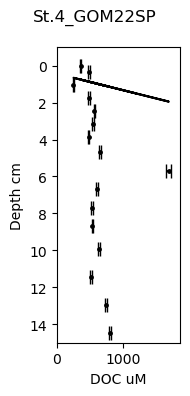

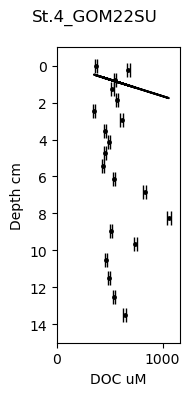

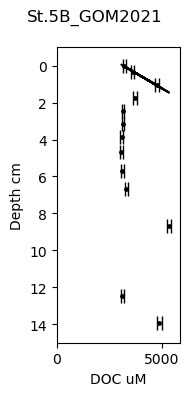

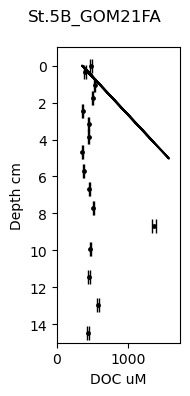

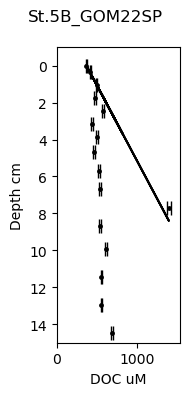

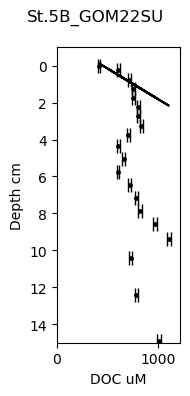

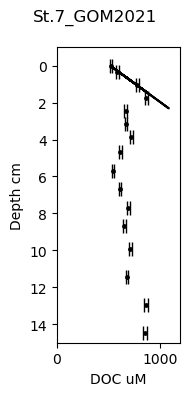

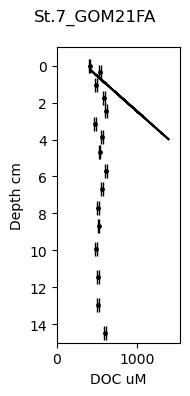

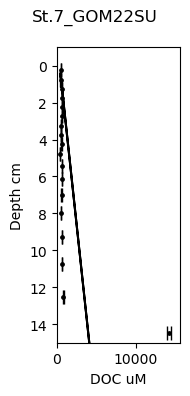

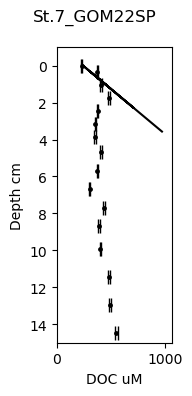

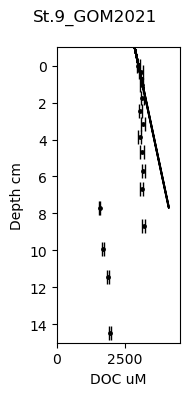

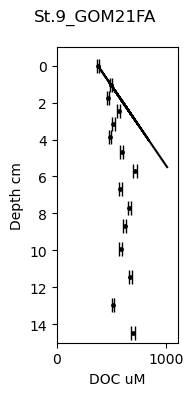

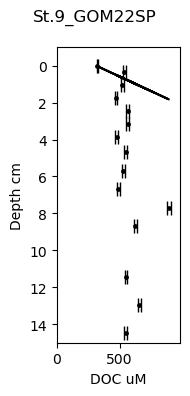

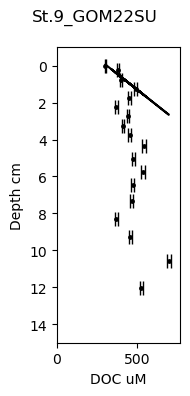

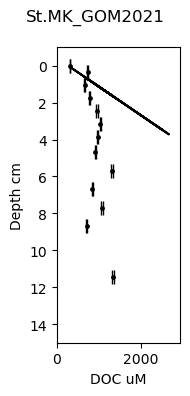

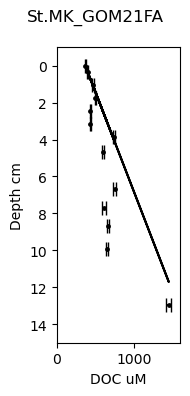

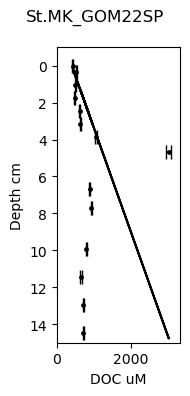

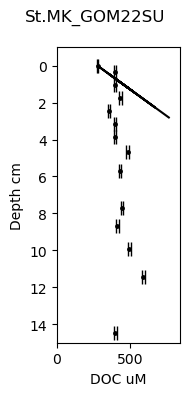

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_12832\3656650087.py:156: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  slopes_doc_pw['por_mean'].fillna(0.85, inplace=True)
C:\Users\hmlbr\AppData\Local\Temp\ipykernel_12832\3656650087.py:157: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


,slope_doc_pw,rsquared_doc_pw,doc_pw_slope_sd,std_err_doc_pw_slope,flux_doc_depth_pw,por_mean,por_sd,std_err_por,por_count,D_doc_low,...,D_doc_mean,D_doc_sd,std_err_D_doc,por_SE,pw_flux_doc,pw_flux_doc_error,Lat,Lon,Stn,Camp
code,,,,,,,,,,,,,,,,,,,,,
St.11_GOM2021,51441.326531,0.080059,100676.020408,101704.793463,1.75,0.894263,0.004941,0.002853,3.0,0.000021,...,0.000006,3.947966e-07,3.945994e-10,0.002853,2.277446,4.510168,28.225724,-89.540904,St.11,GOM2021
St.11_GOM21FA,137288.178082,0.221000,148814.487755,151667.812832,1.75,0.912301,0.010151,0.005861,3.0,0.000022,...,0.000006,4.108847e-07,4.106794e-10,0.005861,6.453406,7.171242,28.209529,-89.591672,St.11,GOM21FA
St.11_GOM22SU,206811.224490,0.301574,181709.183673,185829.488873,1.75,0.911245,0.004821,0.002783,3.0,0.000022,...,0.000006,4.099337e-07,4.097289e-10,0.002783,9.687695,8.735101,28.202880,-89.581503,St.11,GOM22SU
St.12_GOM21FA,348788.941808,0.575834,172830.824261,179806.240515,1.75,0.838128,0.011428,0.006598,3.0,0.000019,...,0.000005,3.467877e-07,3.466145e-10,0.006598,12.712592,6.654496,28.594249,-88.903741,St.12,GOM21FA
St.12_GOM22SU,284209.183673,0.786831,85408.163265,91049.855836,1.75,0.852023,0.016548,0.009554,3.0,0.000019,...,0.000005,3.583816e-07,3.582026e-10,0.009554,10.882596,3.609147,28.593063,-88.878258,St.12,GOM22SU
St.13_GOM21FA,49515.579116,0.488559,6382.790088,7411.895766,6.00,0.889360,0.018345,0.005531,11.0,0.000021,...,0.000006,3.904799e-07,3.902848e-10,0.005531,2.156332,0.336337,28.524193,-89.610854,St.13,GOM21FA
St.13_GOM22SP,73320.708952,1.000000,0.000000,1466.324544,1.75,0.885738,0.008514,0.004916,3.0,0.000021,...,0.000006,3.873055e-07,3.871120e-10,0.004916,3.154154,0.080802,28.507026,-89.622720,St.13,GOM22SP
St.13_GOM22SU,25727.040816,0.091067,46926.020408,47433.986092,1.75,0.879924,0.020249,0.014318,2.0,0.000020,...,0.000006,3.822380e-07,3.820470e-10,0.014318,1.085092,2.018359,28.524547,-89.597871,St.13,GOM22SU
St.14_GOM2021,29186.705857,1.000000,0.000000,602.306998,1.75,0.859448,0.012890,0.007442,3.0,0.000019,...,0.000005,3.646548e-07,3.644726e-10,0.007442,1.147054,0.033682,28.726863,-89.601437,St.14,GOM2021


In [13]:
Frames = []

def doc_flux_cal(code, depth1, depth2): 
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(2, 4)) 
    sub = df_doc_pw_plot[df_doc_pw_plot['code'] == code]
    y = sub['Depth']
    x = sub['NPOC_uM']
    er = sub['NPOC_uM_std']
    axs.scatter(x, y, c="black", s = 6)
    axs.errorbar(x, y, xerr=er, fmt='none', ecolor='black', capsize=5)
    yy = sub.loc[(sub['Depth'] < depth1) & (sub['Depth'] > depth2), 'Depth'].ravel() 
    xx = sub.loc[(sub['Depth'] < depth1) & (sub['Depth'] > depth2), 'NPOC_uM'].ravel()
    
    # Add subplot labels
    axs.set_xlabel('DOC uM')
    axs.set_ylabel('Depth cm')
    axs.set_ylim(15,-1)
    axs.set_xlim(df_doc_pw['NPOC_uM'].min(),sub['NPOC_uM'].max()*1.1)
    
    if len(xx) > 1:
        # Add the slope value to the plot
        slope, intercept, r_value, p_value, std_err = stats.linregress(xx, yy)
        axs.plot(x, intercept + slope * x, c='black')        
        
        xx2 = sub.loc[(sub['Depth'] < depth1) & (sub['Depth'] > depth2), 'Depth'].ravel() / 1000
        yy2 = sub.loc[(sub['Depth'] < depth1) & (sub['Depth'] > depth2), 'NPOC_uM'].ravel() 
        slope, intercept, r_value, p_value, std_err = stats.linregress(xx2, yy2)
        
        slope = slope
        rsquared = r_value**2
        std_err = std_err 
        
        ee2 = sub.loc[(sub['Depth'] < depth1) & (sub['Depth'] > depth2), 'NPOC_uM_std'].ravel() 
        ee2 = ee2/yy2 
        ee2 = ee2*ee2 
        e2 = sum(ee2)
        e2 = np.sqrt(e2)
        e2 = e2 * slope
        e2 = e2 / np.sqrt(len(ee2)) 
        
        slope_std = std_err / np.sqrt(len(xx2)) 
        std_err = slope_std + e2
    
        
    df_p = df_por.loc[df_por['code'] == code]
    df_por_data = df_p.loc[(df_p['depth'] < depth1) & (df_p['depth'] > 0), 'porosity'].ravel() 
    por_mean = df_por_data.mean()
    por_std = df_por_data.std()
    std_err_por = por_std / np.sqrt(len(df_por_data)) 
    por_count = len(df_por_data)

    mw_1 = 100
    mw_2 = 2000

    Do = (1.1 * 1e-3) * (mw_1 ** -.81) 
    D_doc_a = Do / (por_mean * por_mean ** -3 ) 

    Do = (1.1 * 1e-3) * (mw_2 ** -.81) 
    D_doc_b = Do / (por_mean * por_mean ** -3 ) 

    mw = np.arange(1000, 2001, 1)

    Do = (1.1 * 1e-3) * (mw ** -.81) 
    Do_min = Do.min()
    Do_max = Do.max()
    
    D_doc = Do / (por_mean * por_mean ** -3 ) 

    stderr_D_doc = np.std(D_doc, ddof=1) / len(D_doc)
    D_doc_sd = np.std(D_doc) 

    mw_mean = 500
    Do = (1.1 * 1e-3) * (mw_mean ** -.81) 
    mean_D_doc = Do / (por_mean * por_mean ** -3 ) 
    
    dic = {'code':[code],
           'slope_doc_pw':[slope],
           'rsquared_doc_pw':[rsquared], 
           'doc_pw_slope_sd':[slope_std],
           'std_err_doc_pw_slope':[std_err], 
           'flux_doc_depth_pw': [depth1], 
           'por_mean':por_mean,
           'por_sd': por_std,
           'std_err_por': std_err_por,
           'por_count':por_count, 
           'D_doc_low':D_doc_a,
           'D_doc_high':D_doc_b, 
           'D_doc_mean':mean_D_doc, 
           'D_doc_sd': D_doc_sd,
           'std_err_D_doc':stderr_D_doc}
        
    slopes = pd.DataFrame(dic)
    slopes = slopes.set_index('code', drop=True)
    Frames.append(slopes)
        
    # Add subplot labels
    fig.suptitle(code)
    plt.tight_layout()
    fig.set_facecolor('w')
    plt.savefig(f'../Dissertation_projects/Figures/Pore_water_profiles/flux_profiles/doc_{code}.png')
    plt.show()

dep_1_5 = 1.5
dep_1 = 1
dep_2 = -1


doc_flux_cal('St.11_GOM2021', 1.75, dep_2)
doc_flux_cal('St.11_GOM21FA', 1.75, dep_2)
doc_flux_cal('St.11_GOM22SU', 1.75, dep_2)
doc_flux_cal('St.12_GOM21FA', 1.75, dep_2)
doc_flux_cal('St.12_GOM22SU', 1.75, dep_2)
doc_flux_cal('St.13_GOM21FA', 6, dep_2)
doc_flux_cal('St.13_GOM22SP', 1.75, dep_2)
doc_flux_cal('St.13_GOM22SU', 1.75, dep_2)
doc_flux_cal('St.14_GOM2021', 1.75, dep_2)
doc_flux_cal('St.14_GOM21FA', 1.75, dep_2)
doc_flux_cal('St.14_GOM22SP', 1.75, dep_2)
doc_flux_cal('St.14_GOM22SU', 1.75, dep_2)
doc_flux_cal('St.15_GOM2021', 1.75, dep_2)
doc_flux_cal('St.15_GOM21FA', 1, dep_2)
doc_flux_cal('St.15_GOM22SP', 1.75, dep_2)
doc_flux_cal('St.15_GOM22SU', 1.75, dep_2)
doc_flux_cal('St.16_GOM2021', 1.75, dep_2)
doc_flux_cal('St.16_GOM21FA', 1.75, dep_2)
doc_flux_cal('St.16_GOM22SP', 1.75, dep_2)
doc_flux_cal('St.16_GOM22SU', 1.75, dep_2)
doc_flux_cal('St.2_GOM2021', 1.75, dep_2)
doc_flux_cal('St.2_GOM21FA', 2, dep_2)
doc_flux_cal('St.2_GOM22SP', 1.75, dep_2)
doc_flux_cal('St.2_GOM22SU', 1.75, dep_2)
doc_flux_cal('St.4_GOM2021', 1.75, dep_2)
doc_flux_cal('St.4_GOM21FA', 1.75, dep_2)
doc_flux_cal('St.4_GOM22SP', 2, dep_2)
doc_flux_cal('St.4_GOM22SU', 2, dep_2)
doc_flux_cal('St.5B_GOM2021', 1.75, dep_2)
doc_flux_cal('St.5B_GOM21FA', 1.75, dep_2)
doc_flux_cal('St.5B_GOM22SP', 1.75, dep_2)
doc_flux_cal('St.5B_GOM22SU', 1.75, dep_2)
doc_flux_cal('St.7_GOM2021', 1.75, dep_2)
doc_flux_cal('St.7_GOM21FA', 1.75, dep_2)
doc_flux_cal('St.7_GOM22SU', 1.75, dep_2)
doc_flux_cal('St.7_GOM22SP', 1.75, dep_2)
doc_flux_cal('St.9_GOM2021', 1.75, dep_2)
doc_flux_cal('St.9_GOM21FA', 1.75, dep_2)
doc_flux_cal('St.9_GOM22SP', 1.75, dep_2)
doc_flux_cal('St.9_GOM22SU', 1.75, dep_2)
doc_flux_cal('St.MK_GOM2021', 1.75, dep_2)
doc_flux_cal('St.MK_GOM21FA', 1.75, dep_2)
doc_flux_cal('St.MK_GOM22SP', 1.75, dep_2)
doc_flux_cal('St.MK_GOM22SU', 1.75, dep_2)


slopes_doc_pw = pd.concat(Frames, axis=0, ignore_index=False)

slopes_doc_pw['por_mean'].fillna(0.85, inplace=True)
slopes_doc_pw['por_sd'].fillna(0, inplace=True)
slopes_doc_pw['por_SE'] = slopes_doc_pw['por_sd'] / (np.sqrt(slopes_doc_pw['por_count']))
slopes_doc_pw['por_SE'].fillna(0, inplace=True)

#D_doc = 2.6 * (10**-6) / 10000 * (86400) #0.000001728 

#slopes_doc_pw["pw_flux_doc"] = slopes_doc_pw["slope_doc_pw"] * (slopes_doc_pw["flux_doc_depth_pw"] * A * slopes_doc_pw["por_mean"] ) * D_doc
slopes_doc_pw["pw_flux_doc"] = slopes_doc_pw["slope_doc_pw"] * (slopes_doc_pw["por_mean"] ) * (slopes_doc_pw["D_doc_mean"] / 10000 * (86400) )
slopes_doc_pw["pw_flux_doc_error"] = (slopes_doc_pw["std_err_doc_pw_slope"] / slopes_doc_pw["slope_doc_pw"]) + (slopes_doc_pw["por_SE"] / slopes_doc_pw["por_mean"]) + (slopes_doc_pw["std_err_D_doc"] / slopes_doc_pw["D_doc_mean"] )
slopes_doc_pw["pw_flux_doc_error"] = slopes_doc_pw["pw_flux_doc_error"] * slopes_doc_pw["pw_flux_doc"]

#slopes_doc_pw["pw_flux_doc_error"] = slopes_doc_pw["std_err_doc_pw"] * slopes_doc_pw["por_mean"] * slopes_doc_pw["D_doc_mean"] 
#slopes_doc_pw["pw_flux_doc_error_2"] = slopes_doc_pw["std_err_doc_pw_2"] * slopes_doc_pw["por_mean"] * slopes_doc_pw["D_doc_mean"] 


slopes_doc_pw = pd.concat([slopes_doc_pw, df_lat_lon], axis=1, join='outer')
slopes_doc_pw['Stn'] = slopes_doc_pw.index.str.split('_').str[0]
slopes_doc_pw['Camp'] = slopes_doc_pw.index.str.split('_').str[1]
slopes_doc_pw = slopes_doc_pw.dropna(subset=['pw_flux_doc'])

slopes_doc_pw = slopes_doc_pw.drop('St.9_GOM2021', axis=0)
slopes_doc_pw = slopes_doc_pw.drop('St.5B_GOM2021', axis=0)
slopes_doc_pw = slopes_doc_pw.drop('St.4_GOM2021', axis=0)


slopes_doc_pw 

In [14]:
slopes_doc_pw["pw_flux_doc_error"] / slopes_doc_pw["pw_flux_doc"] 

code
St.11_GOM2021    1.980362
St.11_GOM21FA    1.111234
St.11_GOM22SU    0.901670
St.12_GOM21FA    0.523457
St.12_GOM22SU    0.331644
St.13_GOM21FA    0.155976
St.13_GOM22SP    0.025618
St.13_GOM22SU    1.860081
St.14_GOM2021    0.029364
St.14_GOM21FA    0.099064
St.14_GOM22SP    0.563133
St.14_GOM22SU    2.411972
St.15_GOM2021    0.034307
St.15_GOM21FA    0.020852
St.15_GOM22SP    0.185212
St.15_GOM22SU    1.438026
St.16_GOM2021    0.091877
St.16_GOM21FA    0.037091
St.16_GOM22SP    0.743385
St.16_GOM22SU    0.395897
St.2_GOM2021     0.074151
St.2_GOM21FA     0.505052
St.2_GOM22SP     0.500833
St.2_GOM22SU     0.265865
St.4_GOM21FA     0.788810
St.4_GOM22SP     2.715383
St.4_GOM22SU     0.979842
St.5B_GOM21FA    0.973554
St.5B_GOM22SP    0.076886
St.5B_GOM22SU    0.229697
St.7_GOM2021     0.088348
St.7_GOM21FA     1.149900
St.7_GOM22SU     0.704153
St.7_GOM22SP     0.365555
St.9_GOM21FA     0.026752
St.9_GOM22SP     0.607637
St.9_GOM22SU     0.129683
St.MK_GOM2021    0.799078
St.MK_G

In [15]:
slopes_doc_pw["pw_flux_doc"]

code
St.11_GOM2021     2.277446
St.11_GOM21FA     6.453406
St.11_GOM22SU     9.687695
St.12_GOM21FA    12.712592
St.12_GOM22SU    10.882596
St.13_GOM21FA     2.156332
St.13_GOM22SP     3.154154
St.13_GOM22SU     1.085092
St.14_GOM2021     1.147054
St.14_GOM21FA     6.610491
St.14_GOM22SP     4.614289
St.14_GOM22SU     0.359452
St.15_GOM2021    10.964420
St.15_GOM21FA    14.752037
St.15_GOM22SP     8.065378
St.15_GOM22SU     3.090875
St.16_GOM2021    12.783071
St.16_GOM21FA     3.391259
St.16_GOM22SP     2.871026
St.16_GOM22SU    10.850765
St.2_GOM2021      6.635362
St.2_GOM21FA      6.178479
St.2_GOM22SP      4.176038
St.2_GOM22SU     15.065663
St.4_GOM21FA      1.981856
St.4_GOM22SP      0.582342
St.4_GOM22SU      1.076381
St.5B_GOM21FA     1.978069
St.5B_GOM22SP     4.373363
St.5B_GOM22SU     4.845839
St.7_GOM2021     11.408700
St.7_GOM21FA      2.235714
St.7_GOM22SU      4.536960
St.7_GOM22SP      6.712753
St.9_GOM21FA      4.639452
St.9_GOM22SP      6.989487
St.9_GOM22SU      5.520

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_12832\1636371723.py:11: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  yy = sub.loc[(sub['Depth'] < depth1) & (sub['Depth'] > depth2), 'Depth'].ravel()
C:\Users\hmlbr\AppData\Local\Temp\ipykernel_12832\1636371723.py:12: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  xx = sub.loc[(sub['Depth'] < depth1) & (sub['Depth'] > depth2), 'TN_uM'].ravel()
C:\Users\hmlbr\AppData\Local\Temp\ipykernel_12832\1636371723.py:25: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  xx2 = sub.loc[(sub['Depth'] < depth1) & (sub['Depth'] > depth2), 'Depth'].ravel() / 1000
C:\Users\hmlbr\AppData\Local\Temp\ipykernel_

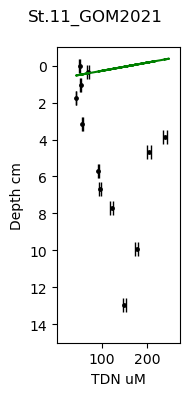

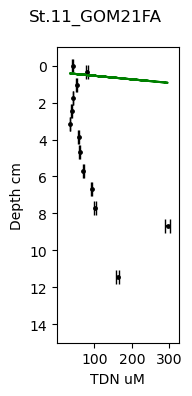

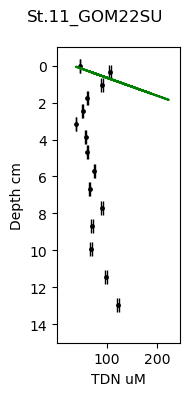

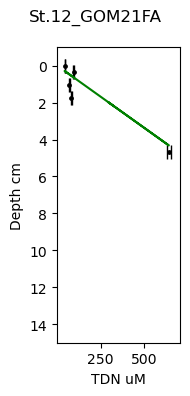

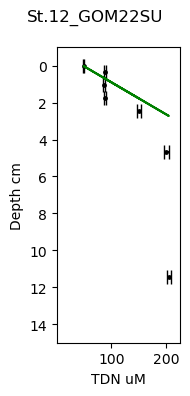

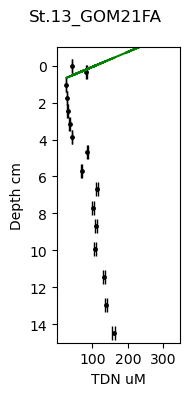

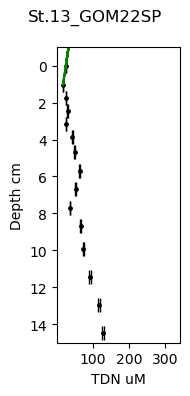

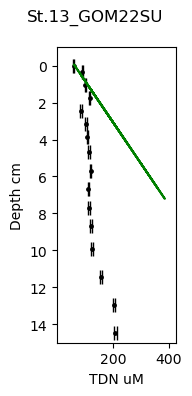

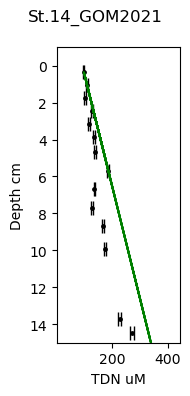

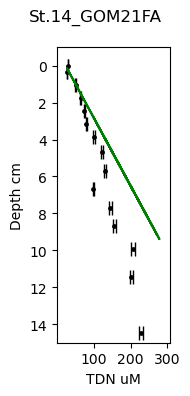

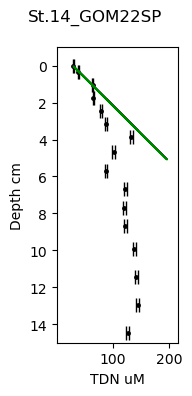

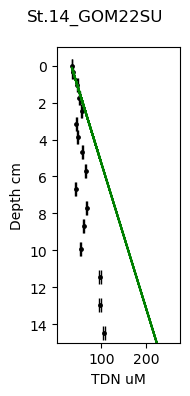

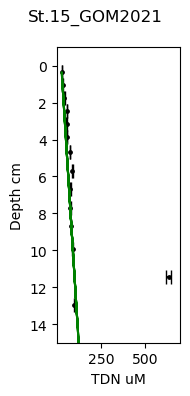

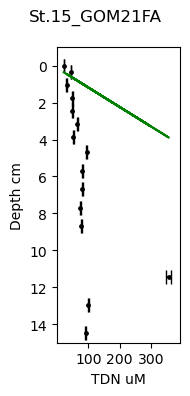

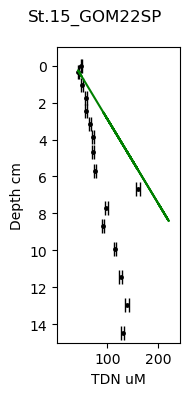

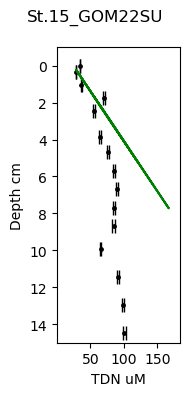

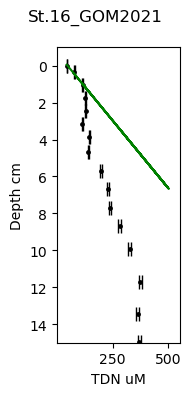

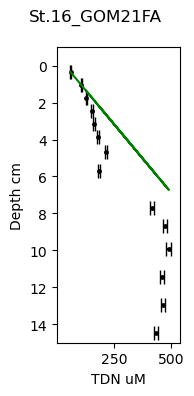

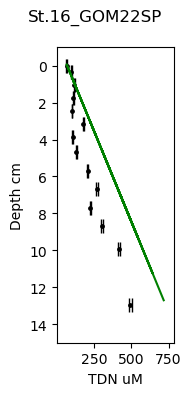

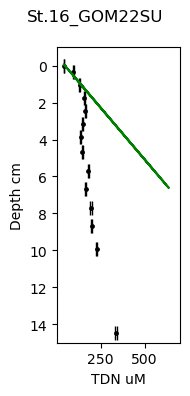

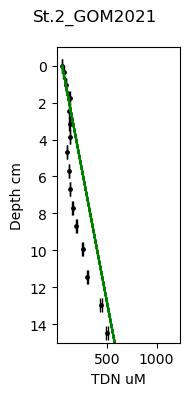

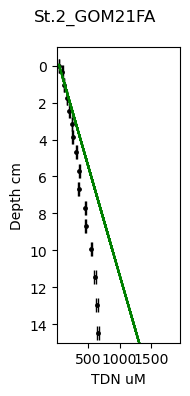

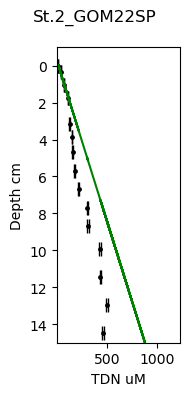

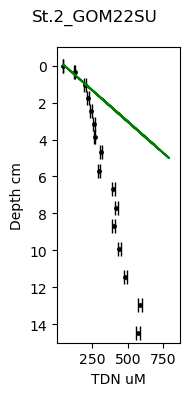

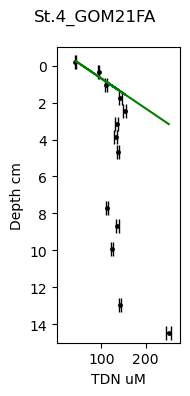

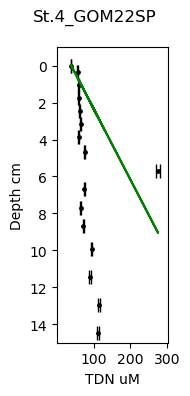

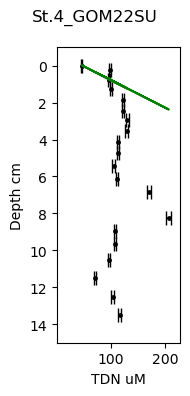

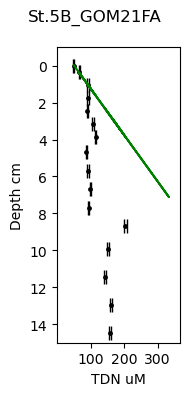

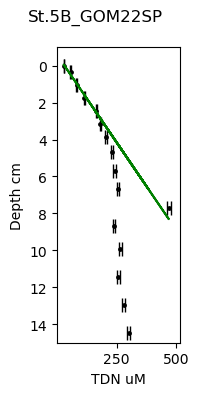

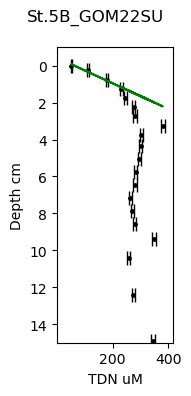

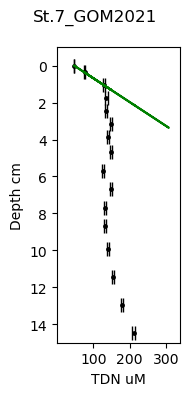

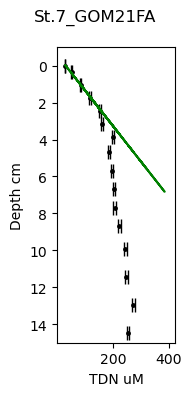

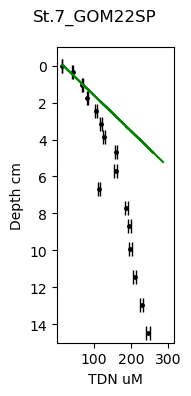

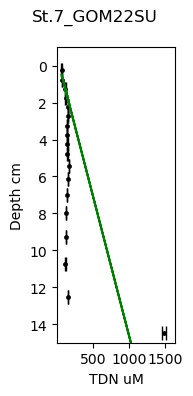

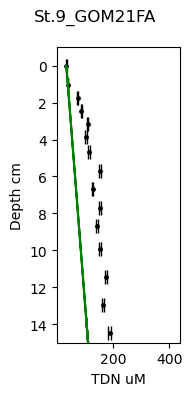

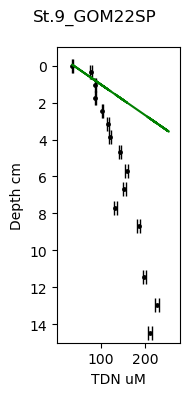

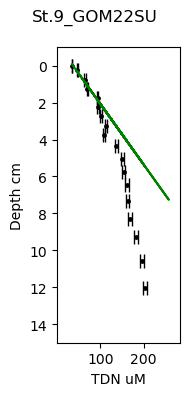

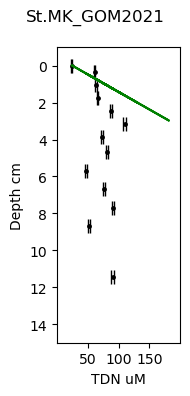

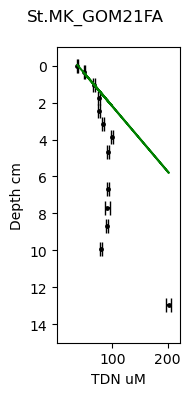

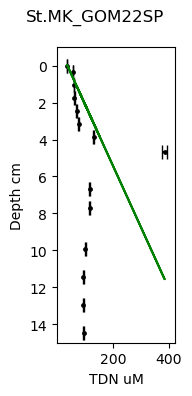

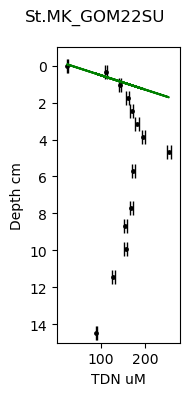

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_12832\1636371723.py:124: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  slopes_tn_pw['por_mean'].fillna(0.85, inplace=True)
C:\Users\hmlbr\AppData\Local\Temp\ipykernel_12832\1636371723.py:125: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.



,slope_tn_pw,rsquared_tn_pw,std_err_tn_pw,std_err_tn_pw_2,flux_tn_depth_pw,por_mean,por_sd,por_count,por_SE,pw_flux_tn,pw_flux_tn_error,pw_flux_tn_error_2,Lat,Lon,Stn,Camp
code,,,,,,,,,,,,,,,,
St.11_GOM2021,-1651.967933,0.007297,19233.921785,19267.802813,1.5,0.894263,0.004941,3.0,0.002853,-0.063819,0.743048,0.744357,28.225724,-89.540904,St.11,GOM2021
St.11_GOM21FA,2628.279543,0.005075,36854.622892,36799.647764,1.5,0.912301,0.010151,3.0,0.005861,0.103584,1.452493,1.450326,28.209529,-89.591672,St.11,GOM21FA
St.11_GOM22SU,32175.655986,0.312881,48325.115476,47681.894283,1.5,0.911245,0.004821,3.0,0.002783,1.266620,1.902356,1.877035,28.202880,-89.581503,St.11,GOM22SU
St.12_GOM21FA,16077.747531,0.108266,46471.851841,46142.105361,1.5,0.838128,0.011428,3.0,0.006598,0.582129,1.682612,1.670673,28.594249,-88.903741,St.12,GOM21FA
St.12_GOM22SU,30334.548102,0.524060,29529.341673,28908.331956,1.5,0.852023,0.016548,3.0,0.009554,1.116535,1.086898,1.064040,28.593063,-88.878258,St.12,GOM22SU
St.13_GOM21FA,-24852.769678,0.201331,48979.950459,49499.790213,1.5,0.910551,0.002025,3.0,0.005531,-0.977604,1.926667,1.947115,28.524193,-89.610854,St.13,GOM21FA
St.13_GOM22SP,-7488.688190,1.000000,-149.828133,0.000000,1.5,0.885738,0.008514,3.0,0.004916,-0.286546,-0.005733,0.000000,28.507026,-89.622720,St.13,GOM22SP
St.13_GOM22SU,35865.524827,0.801924,18672.078183,17824.847927,1.5,0.900173,0.000000,1.0,0.014318,1.394720,0.726110,0.693163,28.524547,-89.597871,St.13,GOM22SU
St.14_GOM2021,16541.871829,1.000000,365.444306,0.000000,1.5,0.859448,0.012890,3.0,0.007442,0.614169,0.013568,0.000000,28.726863,-89.601437,St.14,GOM2021


In [16]:
Frames = []

def doc_flux_cal(code, depth1, depth2): 
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(2, 4)) 
    sub = df_doc_pw_plot.loc[df_doc_pw_plot['code'] == codes[code]]
    y = sub['Depth']
    x = sub['TN_uM']
    er = sub['TN_uM_std']
    axs.scatter(x, y, c="black", s = 6)
    axs.errorbar(x, y, xerr=er, fmt='none', ecolor='black', capsize=5)
    yy = sub.loc[(sub['Depth'] < depth1) & (sub['Depth'] > depth2), 'Depth'].ravel() 
    xx = sub.loc[(sub['Depth'] < depth1) & (sub['Depth'] > depth2), 'TN_uM'].ravel()
    
    # Add subplot labels
    axs.set_xlabel('TDN uM')
    axs.set_ylabel('Depth cm')
    axs.set_ylim(15,-1)
    axs.set_xlim(df_doc_pw['TN_uM'].min(),sub['TN_uM'].max()*1.1)
    
    if len(xx) > 1:
        # Add the slope value to the plot
        slope, intercept, r_value, p_value, std_err = stats.linregress(xx, yy)
        axs.plot(x, intercept + slope * x, c='green')        
        
        xx2 = sub.loc[(sub['Depth'] < depth1) & (sub['Depth'] > depth2), 'Depth'].ravel() / 1000
        yy2 = sub.loc[(sub['Depth'] < depth1) & (sub['Depth'] > depth2), 'TN_uM'].ravel() 
        slope, intercept, r_value, p_value, std_err = stats.linregress(xx2, yy2)
        
        slope = slope
        rsquared = r_value**2
        std_err = std_err 
        
        ee2 = sub.loc[(sub['Depth'] < depth1) & (sub['Depth'] > depth2), 'TN_uM_std'].ravel() 
        ee2 = ee2/yy2 
        ee2 = ee2*ee2 
        e2 = sum(ee2)
        e2 = np.sqrt(e2)
        e2 = e2 * slope
        e2 = e2 / np.sqrt(len(ee2)) 
        
        std_err_2 = std_err + e2
        
    df_p = df_por.loc[df_por['code'] == codes[code]]
    df_por_data = df_p.loc[(df_p['depth'] < depth1) & (df_p['depth'] > 0), 'porosity'].ravel() 
    por_mean = df_por_data.mean()
    por_std = df_por_data.std()
    por_count = len(df_por_data)

    dic = {'code':[codes[code]],
           'slope_tn_pw':[slope],
           'rsquared_tn_pw':[rsquared], 
           'std_err_tn_pw':[std_err_2], 
           'std_err_tn_pw_2':[std_err], 
           'flux_tn_depth_pw': [depth1], 
           'por_mean':por_mean,
           'por_sd': por_std, 
           'por_count':por_count}
        
    slopes = pd.DataFrame(dic)
    slopes = slopes.set_index('code', drop=True)
    Frames.append(slopes)
        
    # Add subplot labels
    fig.suptitle(codes[code])
    plt.tight_layout()
    fig.set_facecolor('w')
    plt.savefig(f'../Dissertation_projects/Figures/Pore_water_profiles/flux_profiles/tdn_{codes[code]}.png')
    plt.show()
    
dep_1_3 = 1.5
dep_1_4 = 1.5
dep_1 = 1.5
dep_2 = -1


doc_flux_cal(0, dep_1_4, dep_2)
doc_flux_cal(1, dep_1_4, dep_2)
doc_flux_cal(2, dep_1_4, dep_2)
doc_flux_cal(3, dep_1_4, dep_2)
doc_flux_cal(4, dep_1_4, dep_2)
doc_flux_cal(5, dep_1_3, dep_2)
doc_flux_cal(6, dep_1_3, dep_2)
doc_flux_cal(7, dep_1_4, dep_2)
doc_flux_cal(8, dep_1_3, dep_2)
doc_flux_cal(9, dep_1_4, dep_2)
doc_flux_cal(10, dep_1_4, dep_2)
doc_flux_cal(11, dep_1_4, dep_2)
doc_flux_cal(12, dep_1_3, dep_2)
doc_flux_cal(13, dep_1_3, dep_2)
doc_flux_cal(14, dep_1_3, dep_2)
doc_flux_cal(15, dep_1_3, dep_2)
doc_flux_cal(16, dep_1_3, dep_2)
doc_flux_cal(17, dep_1_3, dep_2)
doc_flux_cal(18, dep_1_3, dep_2)
doc_flux_cal(19, dep_1_3, dep_2)
doc_flux_cal(20, dep_1_3, dep_2)
doc_flux_cal(21, dep_1_4, dep_2)
doc_flux_cal(22, dep_1_3, dep_2)
doc_flux_cal(23, dep_1_3, dep_2)
#doc_flux_cal(24, dep_1_4, dep_2)
doc_flux_cal(25, dep_1_4, dep_2)
doc_flux_cal(26, dep_1_3, dep_2)
doc_flux_cal(27, dep_1_4, dep_2)
#doc_flux_cal(28, dep_1_4, dep_2)
doc_flux_cal(29, dep_1_4, dep_2)
doc_flux_cal(30, dep_1_3, dep_2)
doc_flux_cal(31, dep_1_4, dep_2)
doc_flux_cal(32, dep_1_3, dep_2)
doc_flux_cal(33, dep_1_4, dep_2)
doc_flux_cal(34, dep_1_3, dep_2)
doc_flux_cal(35, dep_1_3, dep_2)
#doc_flux_cal(36, dep_1_3, dep_2)
doc_flux_cal(37, dep_1_3, dep_2)
doc_flux_cal(38, dep_1_3, dep_2)
doc_flux_cal(39, dep_1_4, dep_2)
doc_flux_cal(40, dep_1_3, dep_2)
doc_flux_cal(41, dep_1_3, dep_2)
doc_flux_cal(42, dep_1_3, dep_2)
doc_flux_cal(43, dep_1_3, dep_2)

slopes_tn_pw = pd.concat(Frames, axis=0, ignore_index=False)

A = np.pi*(4.2388**2) 
slopes_tn_pw['por_mean'].fillna(0.85, inplace=True)
slopes_tn_pw['por_sd'].fillna(0, inplace=True)
slopes_tn_pw['por_SE'] = slopes_doc_pw['por_sd'] / (np.sqrt(slopes_doc_pw['por_count']))
slopes_tn_pw['por_SE'].fillna(0, inplace=True)

D_tn = 5 * (10**-6) / 10000 * (86400)

slopes_tn_pw["pw_flux_tn"] = slopes_tn_pw["slope_tn_pw"] * slopes_tn_pw["por_mean"] * D_tn 
slopes_tn_pw["pw_flux_tn_error"] = slopes_tn_pw["std_err_tn_pw"] * slopes_tn_pw["por_mean"] * D_tn 
slopes_tn_pw["pw_flux_tn_error_2"] = slopes_tn_pw["std_err_tn_pw_2"] * slopes_tn_pw["por_mean"] * D_tn 


slopes_tn_pw = pd.concat([slopes_tn_pw, df_lat_lon], axis=1, join='outer')
slopes_tn_pw['Stn'] = slopes_tn_pw.index.str.split('_').str[0]
slopes_tn_pw['Camp'] = slopes_tn_pw.index.str.split('_').str[1]
slopes_tn_pw = slopes_tn_pw.dropna(subset=['pw_flux_tn'])

slopes_tn_pw 

## Benthic Chamber

#figure calculate Benthic chamber 

# Drop the rows where 'dil_fac' is greater than 6
df_doc_bc = df_doc_bc[df_doc_bc['dil_fac'] <= 2]

#DOC slopes 
df_doc_bc_plot = df_doc_bc[(df_doc_bc['NPOC_uM'] != 0)]
df_doc_bc_plot = df_doc_bc_plot.dropna(subset=["NPOC_uM"])
df_doc_bc_plot = df_doc_bc_plot[df_doc_bc_plot['code'] != 'St.13_GOM22SP']
codes = df_doc_bc_plot['code'].unique()

print(codes)

Frames = []

def doc_flux_cal(code, time1, time2): 
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 3)) 
    sub = df_doc_bc_plot.loc[df_doc_bc_plot['code'] == codes[code]]
    x = sub['Time']
    y = sub['NPOC_uM']
    axs.scatter(x, y, c="black")
    xx = sub.loc[(sub['Time'] < time1) & (sub['Time'] > time2), 'Time'].ravel()
    yy = sub.loc[(sub['Time'] < time1) & (sub['Time'] > time2), 'NPOC_uM'].ravel()
    if len(x) > 1:
        slope, intercept, r_value, p_value, std_err = stats.linregress(xx, yy)
        axs.plot(x, intercept + slope * x, c='black')
        # Add the slope value to the plot
        slope = slope
        rsquared = r_value**2
        std_err = std_err
        
        dic = {'code':[codes[code]],
               'slope_doc_bc':[slope],
               'rsquared_doc_bc':[rsquared], 
               'std_err_doc_bc':[std_err], 
               'flux_time_doc_bc': [time1]}
        
        slopes = pd.DataFrame(dic)
        slopes = slopes.set_index('code', drop=True)
        Frames.append(slopes)
        
    # Add subplot labels
    axs.set_xlabel('Time in Hours')
    axs.set_ylabel('DOC uM')
    axs.set_xlim(0,df_doc_bc['Time'].max())
    axs.set_ylim(df_doc_bc['NPOC_uM'].min(),max(y)*1.1)
    fig.suptitle(codes[code])
    plt.tight_layout()
    fig.set_facecolor('w')
    plt.show()
    
doc_flux_cal(0, 12, 0)
doc_flux_cal(1, 12, 0)
doc_flux_cal(2, 4, 0)
doc_flux_cal(3, 6, 0)
doc_flux_cal(4, 8, 0)
doc_flux_cal(5, 10, .5)
doc_flux_cal(6, 12, 0)
doc_flux_cal(7, 12, 0)
doc_flux_cal(8, 10, 0)
doc_flux_cal(9, 6, .5)
doc_flux_cal(10, 7, .5)
doc_flux_cal(11, 7, 0)
doc_flux_cal(12, 4, .5)
doc_flux_cal(13, 5, 0)
doc_flux_cal(14, 10, 0)
doc_flux_cal(15, 6, 0)
doc_flux_cal(16, 12, 0)
doc_flux_cal(17, 4, 0)
doc_flux_cal(18, 3, 0)
doc_flux_cal(19, 3, 0)
doc_flux_cal(20, 7, 0)
doc_flux_cal(21, 12, 3)
doc_flux_cal(22, 7, 3)
doc_flux_cal(23, 8, 0)
doc_flux_cal(24, 11, 0)
doc_flux_cal(25, 7, 0)
doc_flux_cal(26, 10, 0)
doc_flux_cal(27, 8, 0)
doc_flux_cal(28, 8, 0)

slopes_doc_bc = pd.concat(Frames, axis=0, ignore_index=False)

slopes_doc_bc = pd.concat([slopes_doc_bc, df_hights, df_lat_lon], axis=1, join='outer')
slopes_doc_bc = slopes_doc_bc.dropna(subset=['slope_doc_bc'])

slopes_doc_bc["bc_flux_doc"] = slopes_doc_bc["slope_doc_bc"] * slopes_doc_bc["Hight_m"]* 24 
slopes_doc_bc["bc_flux_doc_error"] = slopes_doc_bc["std_err_doc_bc"] * slopes_doc_bc["Hight_m"]* 24

slopes_doc_bc 

#figure calculate Benthic chamber 

#Nitrogen slops
df_tn_bc_plot = df_doc_bc[(df_doc_bc['TN_uM'] != 0)]
df_tn_bc_plot = df_tn_bc_plot.dropna(subset=["TN_uM"])
df_tn_bc_plot = df_tn_bc_plot[df_tn_bc_plot['code'] != 'St.13_GOM22SP']
codes = df_tn_bc_plot['code'].unique()

print(codes)
len(codes)

Frames = []

def tn_flux_cal(code, time1, time2): 
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 3)) 
    sub = df_tn_bc_plot.loc[df_tn_bc_plot['code'] == codes[code]]
    x = sub['Time']
    y = sub['TN_uM']
    axs.scatter(x, y, c="black")
    xx = sub.loc[(sub['Time'] < time1) & (sub['Time'] > time2), 'Time'].ravel()
    yy = sub.loc[(sub['Time'] < time1) & (sub['Time'] > time2), 'TN_uM'].ravel()
    if len(x) > 1:
        slope, intercept, r_value, p_value, std_err = stats.linregress(xx, yy)
        axs.plot(x, intercept + slope * x, c='g')
        # Add the slope value to the plot
        slope = slope
        rsquared = r_value**2
        std_err = std_err
        
        dic = {'code':[codes[code]],
               'slope_tn_bc':[slope],
               'rsquared_tn_bc':[rsquared], 
               'std_err_tn_bc':[std_err], 
               'flux_time_tn_bc': [time1]}
        
        slopes = pd.DataFrame(dic)
        slopes = slopes.set_index('code', drop=True)
        Frames.append(slopes)
        
    # Add subplot labels
    axs.set_xlabel('Time in Hours')
    axs.set_ylabel('TN uM')
    axs.set_xlim(0,df_doc_bc['Time'].max())
    axs.set_ylim(df_doc_bc['TN_uM'].min(),max(y)*1.1)
    fig.suptitle(codes[code])
    plt.tight_layout()
    fig.set_facecolor('w')
    plt.show()
    
tn_flux_cal(0, 12, 0)
tn_flux_cal(1, 12, .5)
tn_flux_cal(2, 6, 1.5)
tn_flux_cal(3, 5, 0)
tn_flux_cal(4, 8, 0)
tn_flux_cal(5, 10, .5)
tn_flux_cal(6, 12, 3)
tn_flux_cal(7, 12, 0)
tn_flux_cal(8, 10, 0)
tn_flux_cal(9, 6, .5)
tn_flux_cal(10, 7, 1.5)
tn_flux_cal(11, 10, 0)
tn_flux_cal(12, 4, .5)
tn_flux_cal(13, 5, 0)
tn_flux_cal(14, 9, 0)
tn_flux_cal(15, 6, 0)
tn_flux_cal(16, 3, 0)
tn_flux_cal(17, 4, 0)
tn_flux_cal(18, 3, 0)
tn_flux_cal(19, 3, 0)
tn_flux_cal(20, 7, 0)
tn_flux_cal(21, 3, 0)
tn_flux_cal(22, 7, 3)
tn_flux_cal(23, 8, 0)
tn_flux_cal(24, 7, 0)
tn_flux_cal(25, 10, 0)
tn_flux_cal(26, 10, 0)
tn_flux_cal(27, 8, 0)
tn_flux_cal(28, 8, 1)

slopes_tn_bc = pd.concat(Frames, axis=0, ignore_index=False)

slopes_tn_bc = pd.concat([slopes_tn_bc, df_hights, df_lat_lon], axis=1, join='outer')
slopes_tn_bc = slopes_tn_bc.dropna(subset=['slope_tn_bc'])

slopes_tn_bc["bc_flux_tn"] = slopes_tn_bc['slope_tn_bc'] * slopes_tn_bc["Hight_m"] *24 
slopes_tn_bc["bc_flux_tn_error"] = slopes_tn_bc["std_err_tn_bc"] * slopes_tn_bc["Hight_m"]* 24

slopes_tn_bc 

slopes_doc_bc.to_csv('../Dissertation_projects/Data/Stats_data_sets/Flux_doc_bc.csv')
slopes_doc_bc

slopes_tn_bc.to_csv('../Dissertation_projects/Data/Stats_data_sets/Flux_tn_bc.csv')
slopes_tn_bc

In [17]:
slopes_doc_pw.to_csv('../Dissertation_projects/Data/Stats_data_sets/Flux_doc_pw.csv')
slopes_doc_pw

,slope_doc_pw,rsquared_doc_pw,doc_pw_slope_sd,std_err_doc_pw_slope,flux_doc_depth_pw,por_mean,por_sd,std_err_por,por_count,D_doc_low,...,D_doc_mean,D_doc_sd,std_err_D_doc,por_SE,pw_flux_doc,pw_flux_doc_error,Lat,Lon,Stn,Camp
code,,,,,,,,,,,,,,,,,,,,,
St.11_GOM2021,51441.326531,0.080059,100676.020408,101704.793463,1.75,0.894263,0.004941,0.002853,3.0,0.000021,...,0.000006,3.947966e-07,3.945994e-10,0.002853,2.277446,4.510168,28.225724,-89.540904,St.11,GOM2021
St.11_GOM21FA,137288.178082,0.221000,148814.487755,151667.812832,1.75,0.912301,0.010151,0.005861,3.0,0.000022,...,0.000006,4.108847e-07,4.106794e-10,0.005861,6.453406,7.171242,28.209529,-89.591672,St.11,GOM21FA
St.11_GOM22SU,206811.224490,0.301574,181709.183673,185829.488873,1.75,0.911245,0.004821,0.002783,3.0,0.000022,...,0.000006,4.099337e-07,4.097289e-10,0.002783,9.687695,8.735101,28.202880,-89.581503,St.11,GOM22SU
St.12_GOM21FA,348788.941808,0.575834,172830.824261,179806.240515,1.75,0.838128,0.011428,0.006598,3.0,0.000019,...,0.000005,3.467877e-07,3.466145e-10,0.006598,12.712592,6.654496,28.594249,-88.903741,St.12,GOM21FA
St.12_GOM22SU,284209.183673,0.786831,85408.163265,91049.855836,1.75,0.852023,0.016548,0.009554,3.0,0.000019,...,0.000005,3.583816e-07,3.582026e-10,0.009554,10.882596,3.609147,28.593063,-88.878258,St.12,GOM22SU
St.13_GOM21FA,49515.579116,0.488559,6382.790088,7411.895766,6.00,0.889360,0.018345,0.005531,11.0,0.000021,...,0.000006,3.904799e-07,3.902848e-10,0.005531,2.156332,0.336337,28.524193,-89.610854,St.13,GOM21FA
St.13_GOM22SP,73320.708952,1.000000,0.000000,1466.324544,1.75,0.885738,0.008514,0.004916,3.0,0.000021,...,0.000006,3.873055e-07,3.871120e-10,0.004916,3.154154,0.080802,28.507026,-89.622720,St.13,GOM22SP
St.13_GOM22SU,25727.040816,0.091067,46926.020408,47433.986092,1.75,0.879924,0.020249,0.014318,2.0,0.000020,...,0.000006,3.822380e-07,3.820470e-10,0.014318,1.085092,2.018359,28.524547,-89.597871,St.13,GOM22SU
St.14_GOM2021,29186.705857,1.000000,0.000000,602.306998,1.75,0.859448,0.012890,0.007442,3.0,0.000019,...,0.000005,3.646548e-07,3.644726e-10,0.007442,1.147054,0.033682,28.726863,-89.601437,St.14,GOM2021


In [18]:
slopes_tn_pw.to_csv('../Dissertation_projects/Data/Stats_data_sets/Flux_tn_pw.csv')
slopes_tn_pw

,slope_tn_pw,rsquared_tn_pw,std_err_tn_pw,std_err_tn_pw_2,flux_tn_depth_pw,por_mean,por_sd,por_count,por_SE,pw_flux_tn,pw_flux_tn_error,pw_flux_tn_error_2,Lat,Lon,Stn,Camp
code,,,,,,,,,,,,,,,,
St.11_GOM2021,-1651.967933,0.007297,19233.921785,19267.802813,1.5,0.894263,0.004941,3.0,0.002853,-0.063819,0.743048,0.744357,28.225724,-89.540904,St.11,GOM2021
St.11_GOM21FA,2628.279543,0.005075,36854.622892,36799.647764,1.5,0.912301,0.010151,3.0,0.005861,0.103584,1.452493,1.450326,28.209529,-89.591672,St.11,GOM21FA
St.11_GOM22SU,32175.655986,0.312881,48325.115476,47681.894283,1.5,0.911245,0.004821,3.0,0.002783,1.266620,1.902356,1.877035,28.202880,-89.581503,St.11,GOM22SU
St.12_GOM21FA,16077.747531,0.108266,46471.851841,46142.105361,1.5,0.838128,0.011428,3.0,0.006598,0.582129,1.682612,1.670673,28.594249,-88.903741,St.12,GOM21FA
St.12_GOM22SU,30334.548102,0.524060,29529.341673,28908.331956,1.5,0.852023,0.016548,3.0,0.009554,1.116535,1.086898,1.064040,28.593063,-88.878258,St.12,GOM22SU
St.13_GOM21FA,-24852.769678,0.201331,48979.950459,49499.790213,1.5,0.910551,0.002025,3.0,0.005531,-0.977604,1.926667,1.947115,28.524193,-89.610854,St.13,GOM21FA
St.13_GOM22SP,-7488.688190,1.000000,-149.828133,0.000000,1.5,0.885738,0.008514,3.0,0.004916,-0.286546,-0.005733,0.000000,28.507026,-89.622720,St.13,GOM22SP
St.13_GOM22SU,35865.524827,0.801924,18672.078183,17824.847927,1.5,0.900173,0.000000,1.0,0.014318,1.394720,0.726110,0.693163,28.524547,-89.597871,St.13,GOM22SU
St.14_GOM2021,16541.871829,1.000000,365.444306,0.000000,1.5,0.859448,0.012890,3.0,0.007442,0.614169,0.013568,0.000000,28.726863,-89.601437,St.14,GOM2021
